# Topic modelling with Gensim : the LDA algorithm on the Statistics Explained articles

LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

### 1. Loading of the required libraries and vocabularies.
***



In [6]:
import gensim
import pandas as pd
import numpy as np

import re
import pprint

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from pprint import pprint



### Step 2. Pre-processing

* Read a file with scraped content from the Statistics Explained articles. This is the file currently produced with an additional column "raw content" which gathers all titles and contents from an article (a refinement here can be to give more weight to the title words).
* In later versions, the **corresponding tables will be directly exported from the database**.
* Discard records with duplicate abstracts and/or titles and/or contents.
* Apply some cleansing steps in the contents: replace anything except digits,letters,commas and dots by space, remove more than one consecutive spaces and other redundant spaces. 

There are 615 articles available for the analysis.


In [7]:
dat = pd.read_excel('articles_4_30_12_26.xlsx')
dat = dat[['title','abstract','categories','raw content']]

dat = dat.dropna(axis=0,subset=["title"])
dat = dat.dropna(axis=0,subset=["abstract"])
dat = dat.dropna(axis=0,subset=["raw content"])
dat.reset_index(drop=True, inplace=True)

dat['raw content'] = dat['raw content'].apply(lambda x: re.sub("[^a-z\\.,A-Z0-9]", " ",x)) ## replace anything except digits,letters,comma and dot by space 
dat['raw content'] = dat['raw content'].apply(lambda x: re.sub(' +', ' ',x)) ## remove more than one spaces
dat['raw content'] = dat['raw content'].apply(lambda x: re.sub('^ +| +$', '',x)) ## remove start and end spaces
dat['raw content'] = dat['raw content'].apply(lambda x: re.sub(' ,',',',x)) ## space-comma-space -> comma-space

dat

,title,abstract,categories,raw content
0,Air safety statistics in the EU,Detailed data from the European Aviation Safe...,"['Air', 'Passengers', 'Statistical article', '...",Overview of fatalities in air transport in the...
1,ASEAN-EU - international trade in goods statis...,This article provides a picture of the inte...,"['Non-EU countries', 'Trade in goods', 'Statis...",ASEAN countries trade in goods with main partn...
2,Air pollution statistics - emission inventories,This article is about emissions of air pollut...,"['Air pollution', 'Environment', 'Health', 'He...",General overview Air pollution harms human hea...
3,Absences from work - quarterly statistics,Absences from work can be classified into two...,"['Employment', 'Labour market', 'Statistical a...",Absences from work sharply increase in first h...
4,Annual national accounts - evolution of the in...,This article explains the income components of...,"['Authored article', 'National accounts (incl....",Shares of income components to GDP in 2019 In ...
...,...,...,...,...
610,Accommodation and food service statistics - NA...,This article presents an overview of statist...,"['Services', 'Statistical article', 'Structura...",Structural profile The accommodation and food ...
611,Accidents at work statistics,This article presents a set of main statistica...,"['Accidents at work', 'Health', 'Health and sa...","Number of accidents In 2018, there were 3.1 mi..."
612,Accidents at work - statistics on causes and c...,This article presents a set of main statistica...,"['Accidents at work', 'Health', 'Health and sa...",Workstation accidents Non fatal accidents In 2...
613,Accidents at work - statistics by economic act...,This article presents a set of main statistic...,"['Accidents at work', 'Health', 'Health and sa...",Developments over time Non fatal accidents In ...


### 3. Pre-processing input data (cont).
***

Next we define a function _sent_to_words_ which accepts a series of texts and:
* Converts everything to lowercase and drops accents, 
* Deletes stop words, 
* Tokenizes the texts, 
* Apply Porter's stemmer and keeps as final tokens the resulting terms with minimum length 5. 

We call this function with the articles definitions in column "raw content" of dataframe _dat_. The result, _texts_ is a nested list with 615 outer elements corresponding to the SE articles. The inner lists contain the tokens for each text.

In [8]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
def sent_to_words(sentences):
    p = PorterStemmer()
    for sentence in sentences:
        sentence = str(gensim.utils.simple_preprocess(sentence, deacc=True))
        sentence = remove_stopwords(sentence) 
        tokens = gensim.utils.tokenize(sentence)
        sentence = [p.stem(token) for token in tokens if len(p.stem(token)) >= 5] ##minimum length = 5 
        yield(sentence)
                
texts = list(sent_to_words(dat['raw content']))
print('\nFirst text: \n',texts[:1])
print('\nTotal texts: ',len(texts),'\n')



First text: 
 [['overview', 'fatal', 'transport', 'annual', 'safeti', 'review', 'european', 'aviat', 'safeti', 'agenc', 'highlight', 'except', 'global', 'airlin', 'safeti', 'fewer', 'fatal', 'industri', 'histori', 'death', 'annual', 'safeti', 'review', 'remind', 'there', 'complac', 'after', 'increas', 'observ', 'person', 'total', 'aviat', 'accid', 'territori', 'involv', 'aircraft', 'regist', 'member', 'state', 'european', 'union', 'record', 'slight', 'decreas', 'fatal', 'everi', 'accid', 'fatal', 'regist', 'categori', 'gener', 'aviat', 'figur', 'specif', 'categori', 'aircraft', 'maximum', 'categori', 'compris', 'small', 'aeroplan', 'glider', 'microlight', 'balloon', 'compar', 'which', 'where', 'transport', 'fatal', 'record', 'period', 'categori', 'commerci', 'transport', 'fatal', 'categori', 'fatal', 'fatal', 'regist', 'aerial', 'accid', 'while', 'person', 'gener', 'aviat', 'accid', 'involv', 'aircraft', 'accid', 'gener', 'aviat', 'under', 'fatal', 'occur', 'countri', 'franc', 'fatal'

### 4. Grid search for the selection of the best LDA model.
***

Before running the grid search, we create a vocabulary from _texts_ with name _id2word_. This is a dictionary the numeric ids of the terms as keys and the terms themselves as values. The terms are initially sorted alphabetically. 

In the grid search, before calling _ldamodel.LdaModel()_ we create a mapping with name _corpus_ of texts to terms in the bag-of-words (BOW) format. Each text is mapped into a list with 2-tuples: (word id, word count in each text). The terms in the vocabulary are then re-ordered according to their order of appearance in the texts. We set the bounds on the appearance of terms in the texts with the function _filter_extremes()_ on the _id2word_ vocabulary. 
 
The parameters in the call of the function _ldamodel.LdaModel()_ and the number of topics were selected by trial and error and also through **grid search runs**. We run several such runs with different combinations and values for the hyper-parameters. 

The quality measure for the selection of the best LDA model is the coherence score. This is based on the work in Röder, M., Both, A., & Hinneburg, A. (2015, February). Exploring the space of topic coherence measures. In *Proceedings of the eighth ACM international conference on Web search and data mining* (pp. 399-408), available [here](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). 

The (disabled) code for an **indicative** grid search run is shown below. Do **not** comment-out the first line. 


In [9]:
%%script false --no-raise-error ## DO NOT UN-COMMENT THIS! THIS CELL IS NOT SUPPOSED TO RUN

from gensim import corpora
from gensim.models import CoherenceModel
from itertools import product
import copy

id2word = corpora.Dictionary(texts) #Gensim creates a unique id for each word in the document. 
#id2word_keep = id2word
id2word_keep = copy.deepcopy(id2word)

def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

dictionary = {'num_topics':[20, 30, 40], 'passes': [50], 'alpha': ['auto'], 
              'decay': [0.3, 0.5, 0.75], 'iterations':[300],'lb':[0.01, 0.05], 'ub':[0.5,0.75]}

#dictionary = {'num_topics':[20, 30, 40], 'passes': [40,50,60], 'alpha': ['symmetric', 'asymmetric','auto'], 
#              'decay': [0.3, 0.5, 0.75], 'iterations':[300,500],'lb':[0.01, 0.05], 'ub':[0.5,0.75]}



grid = expand_grid(dictionary)
print(grid)
best_coherence = 0
best_params = -1
for i in range(len(grid)):
    
   

    #Create Dictionary
    #id2word = id2word_keep 
    id2word = copy.deepcopy(id2word_keep)
    id2word.filter_extremes(no_below=grid.loc[i,'lb']*len(texts), no_above=grid.loc[i,'ub'])

    print('Terms in the vocabulary: ',len(id2word),'\n')

    corpus = [id2word.doc2bow(text) for text in texts] 

    print('Testing with row ',i+1,' of ',len(grid),'\n')
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=grid.loc[i,'num_topics'],
                                           random_state=100,
                                           update_every=0,
                                           passes=grid.loc[i,'passes'],
                                           alpha=grid.loc[i,'alpha'],
                                           iterations=grid.loc[i,'iterations'],
                                           decay = grid.loc[i,'decay'],
                                           per_word_topics=True,
                                           eval_every=None)
    
    print(grid.loc[i,:])
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda,'\n')
    grid.loc[i,'Coherence'] = coherence_lda
    
    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_params = i
        
    print('\nBest so far: ',best_coherence,' at row ',best_params+1,'\n')    

grid.to_excel('grid_SE.xlsx')

### 5. Fitting the selected LDA model
***

The next code shows the fitting of the LDA model with the selected parameters found (20 topics). Compared to the runs with the SE Glossary entries, we found that we had to lower the _decay_ parameter. Also, as expected, the upper bound on the percentage of occurence of terms in the articles had to be set to a much lower value, 0.5. The coherence value of 0.54 is considered quite good. We store the fitted model in an object _lda_model_.

In [10]:

lower_bound = 0.01
upper_bound = 0.5

from gensim import corpora

#Create Dictionary
id2word = corpora.Dictionary(texts) #Gensim creates a unique id for each word in the document. 
id2word.filter_extremes(no_below=lower_bound*len(texts), no_above=upper_bound)

print(id2word,'\n')

corpus = [id2word.doc2bow(text) for text in texts] 

print('Firsτ 2 texts in BOW format:\n')
print(corpus[:2],'\n')
print('First 2 texts in BOW format together with terms:\n')
for i in range(2):
    print([(id2word[term_id],term_id,freq) for (term_id,freq) in corpus[i]])

print('\nTotal texts: ',len(corpus))

num_topics = 20
passes = 50
alpha= 'auto'
iterations = 300 
decay = 0.30 

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=0,
                                           passes=passes,
                                           alpha=alpha,
                                           iterations=iterations,
                                           decay = decay,
                                           per_word_topics=True,
                                           eval_every=None)


from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Dictionary(1827 unique tokens: ['accid', 'actual', 'addit', 'advertis', 'after']...) 

Firsτ 2 texts in BOW format:

[[(0, 37), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 4), (11, 1), (12, 1), (13, 1), (14, 15), (15, 1), (16, 1), (17, 2), (18, 12), (19, 1), (20, 1), (21, 2), (22, 1), (23, 6), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 5), (31, 1), (32, 2), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 5), (39, 2), (40, 1), (41, 45), (42, 2), (43, 1), (44, 1), (45, 5), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 20), (57, 2), (58, 1), (59, 1), (60, 1), (61, 2), (62, 2), (63, 1), (64, 8), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 2), (71, 9), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 2), (79, 33), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 2), (87, 2), (88, 5), (89, 1), (90, 1), (91, 1), (92, 1), (93, 3), (94, 2), (95, 2), (96, 4), (97, 1), (98

### 6. Identification of the dominant topic per document.
***
In this section, we identify the dominant topic, its weight and its keywords, for each document. We define a dataframe _df_topic_sents_keywords_  in order to store these results. As it will be seen later, these are very useful as **complementary information to find and/or verify the interpretation of the topics**.

In function _format_topics_sentences()_ below, the list _ldamodel[corpus]_ has one nested list element per text. Each nested list contains tuples of the form (topic, contribution). We sort the firts element of each nested list by descending contribution to find the dominant topic and then, we retrieve for this topic, the list _wp_ of tuples (word, probability) for the most probable words, using the function _ldamodel.show_topic()_. We join these words into a list and put the result in column 'Topic_Keywords' of the dataframe.  


In [11]:
def format_topics_sentences(ldamodel=None, corpus=corpus):

    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]): 
        row = row_list[0]
        row = sorted(row, key=lambda x: (x[1]), reverse=True) ## sort the nested list by descending contribution
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        topic_num, prop_topic = row[0]
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original tokenized text and title to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, dat[['title','categories','abstract']]], axis=1)
    return(sent_topics_df)

In [12]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus)
df_topic_sents_keywords.rename(columns = {0:'Text tokenized definition'}, inplace = True)
df_topic_sents_keywords.rename(columns = {'title':'Text title','categories':'Text categories','abstract':'Text abstract'}, inplace = True)
df_topic_sents_keywords = df_topic_sents_keywords[['Text title','Text tokenized definition','Text categories','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']]
df_topic_sents_keywords['Dominant_Topic'] = df_topic_sents_keywords['Dominant_Topic'].astype(int)
df_topic_sents_keywords


,Text title,Text tokenized definition,Text categories,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,Air safety statistics in the EU,"[overview, fatal, transport, annual, safeti, r...","['Air', 'Passengers', 'Statistical article', '...",7,0.5372,"activ, accid, servic, fatal, sector, emploi, p..."
1,ASEAN-EU - international trade in goods statis...,"[asean, countri, trade, partner, largest, trad...","['Non-EU countries', 'Trade in goods', 'Statis...",3,0.9749,"billion, export, trade, china, partner, millio..."
2,Air pollution statistics - emission inventories,"[gener, overview, pollut, human, health, envir...","['Air pollution', 'Environment', 'Health', 'He...",13,0.8452,"water, european, develop, target, measur, sust..."
3,Absences from work - quarterly statistics,"[absenc, sharpli, increas, first, decreas, qua...","['Employment', 'Labour market', 'Statistical a...",19,0.7886,"employ, young, peopl, women, point, labour, qu..."
4,Annual national accounts - evolution of the in...,"[share, incom, compon, compens, employe, large...","['Authored article', 'National accounts (incl....",12,0.7341,"expenditur, benefit, govern, financi, social, ..."
...,...,...,...,...,...,...
610,Accommodation and food service statistics - NA...,"[structur, profil, accommod, servic, sector, r...","['Services', 'Statistical article', 'Structura...",5,0.7466,"region, sector, economi, employ, person, finan..."
611,Accidents at work statistics,"[number, accid, there, million, fatal, accid, ...","['Accidents at work', 'Health', 'Health and sa...",7,0.9987,"activ, accid, servic, fatal, sector, emploi, p..."
612,Accidents at work - statistics on causes and c...,"[workstat, accid, fatal, accid, million, fatal...","['Accidents at work', 'Health', 'Health and sa...",7,0.9929,"activ, accid, servic, fatal, sector, emploi, p..."
613,Accidents at work - statistics by economic act...,"[develop, fatal, accid, there, million, fatal,...","['Accidents at work', 'Health', 'Health and sa...",7,0.9993,"activ, accid, servic, fatal, sector, emploi, p..."


### 7. Most representative document for each topic.
***

Here, we are searching for the reverse, i.e. we want to find the document that best represents a given topic.We create the dataframe _sent_topics_sorteddf_mallet_ to store the results.

In [13]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords[['Text title','Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']].groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                             axis=0)

sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

sent_topics_sorteddf_mallet.columns = ['Text title','Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords' ]
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet[['Topic_Num', 'Topic_Perc_Contrib', 'Topic Keywords','Text title']]

sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Topic Keywords,Text title
0,0,0.9114,"popul, peopl, older, birth, project, chang, wo...",Population projections in the EU
1,1,0.9971,"product, price, million, quarter, agricultur, ...",Farms and farmland in the European Union - sta...
2,2,0.9977,"energi, consumpt, product, electr, emiss, rene...",Production of lignite in the EU - statistics
3,3,0.9976,"billion, export, trade, china, partner, millio...",Norway-EU - international trade in goods stati...
4,4,0.8063,"household, cultur, internet, adult, onlin, poi...",Digital economy and society statistics - house...
5,5,0.9989,"region, sector, economi, employ, person, finan...","Water supply, sewerage, waste management and r..."
6,6,0.9493,"person, group, emploi, health, children, women...",Main place of work and commuting time - statis...
7,7,0.9993,"activ, accid, servic, fatal, sector, emploi, p...",Accidents at work - statistics by economic act...
8,8,0.8624,"peopl, activ, popul, particip, adult, famili, ...",Social participation and integration statistics
9,9,0.9915,"citizen, foreign, resid, nation, permit, first...",Asylum quarterly report


### 8. The topics as a mix of keywords.
***

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes with a certain weight to the topic.  This mix of keywords (limited to the top 10 keywords) is shown below, for each topic.


In [14]:
pprint(lda_model.print_topics())

## equivalently:
##for i in range(num_topics):
##    print([(id2word[term_id],prob) for (term_id,prob) in lda_model.get_topic_terms(i,topn=10)],'\n')

[(0,
  '0.120*"popul" + 0.053*"peopl" + 0.049*"older" + 0.031*"birth" + '
  '0.027*"project" + 0.024*"chang" + 0.023*"women" + 0.022*"expect" + '
  '0.013*"sport" + 0.013*"person"'),
 (1,
  '0.063*"product" + 0.031*"price" + 0.028*"million" + 0.015*"quarter" + '
  '0.015*"agricultur" + 0.014*"industri" + 0.014*"produc" + 0.014*"crisi" + '
  '0.011*"develop" + 0.011*"declin"'),
 (2,
  '0.098*"energi" + 0.057*"consumpt" + 0.057*"product" + 0.034*"electr" + '
  '0.033*"emiss" + 0.017*"renew" + 0.016*"gross" + 0.016*"final" + '
  '0.015*"primari" + 0.014*"environment"'),
 (3,
  '0.109*"billion" + 0.105*"export" + 0.094*"trade" + 0.027*"china" + '
  '0.026*"partner" + 0.024*"million" + 0.022*"product" + 0.022*"manufactur" + '
  '0.020*"world" + 0.018*"extra"'),
 (4,
  '0.079*"household" + 0.061*"cultur" + 0.059*"internet" + 0.032*"adult" + '
  '0.019*"onlin" + 0.017*"point" + 0.017*"servic" + 0.017*"comput" + '
  '0.016*"proport" + 0.015*"access"'),
 (5,
  '0.148*"region" + 0.035*"sector" +

### 9. Dominant topics.
***


To better understand the volume and distribution of topics, we construct the dataframe _df_dominant_topics_ with relevant information.


In [15]:
#Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,7,"activ, accid, servic, fatal, sector, emploi, p...",18.0,0.0293
1,3,"billion, export, trade, china, partner, millio...",67.0,0.1089
2,13,"water, european, develop, target, measur, sust...",37.0,0.0602
3,19,"employ, young, peopl, women, point, labour, qu...",54.0,0.0878
4,12,"expenditur, benefit, govern, financi, social, ...",17.0,0.0276
...,...,...,...,...
610,5,"region, sector, economi, employ, person, finan...",NaN,NaN
611,7,"activ, accid, servic, fatal, sector, emploi, p...",NaN,NaN
612,7,"activ, accid, servic, fatal, sector, emploi, p...",NaN,NaN
613,7,"activ, accid, servic, fatal, sector, emploi, p...",NaN,NaN


### 10. Visualization of the topics.
***

To visualize the fitted LDA model we use the _pyLDAvis_ package. This is the Python porting of the R package _LDAvis_, see [LDAvis vignette](https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf) for details and Chuang, Jason, Manning, Christopher D., and Heer, Jeffrey (2012). Termite: Visualization Techniques for Assessing Textual Topic Models, *Advanced Visual Interfaces* for the theory behind the visualization algorithm. The paper is available [here](https://dl.acm.org/doi/pdf/10.1145/2254556.2254572?casa_token=q2BavKP415QAAAAA:MhcYHzz4PJpC7dNkkm12GL-ohQRUXBgumPJ9l1t_5n3M4qVE1kdDqKGfPmtnR7qbale_ukS-2nJs). 

Note that the parameter _sort_topics=False_ in the call to function _pyLDAvis.gensim_models.prepare()_ is necessary, otherwise the numbering of the topics is different than the one in the rest of the analysis. Also, **the numbering of the topics start from zero**.

In [16]:
#Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.111604 -0.035171       1        1  4.632119
1     -0.163490  0.006107       2        1  7.135528
2     -0.216000  0.060219       3        1  3.918167
3     -0.198399 -0.324222       4        1  6.583111
4      0.103450  0.040828       5        1  3.002511
5     -0.058841  0.068040       6        1  5.779392
6      0.163263  0.008039       7        1  5.322621
7     -0.026928  0.110505       8        1  3.651398
8      0.238637  0.001623       9        1  3.722790
9      0.065964 -0.061204      10        1  3.714357
10    -0.125580  0.028626      11        1  3.265543
11     0.100401 -0.058568      12        1  3.933181
12    -0.079389  0.096306      13        1  6.775399
13    -0.109004  0.155030      14        1  7.492370
14    -0.100632  0.112478      15        1  5.322612
15     0.040945 -0.028740      16        1  4.044870
16     0.118264 -0.084177      17        1  5.171281
17    -0.139183 -0.099449      18        1  3.693129
18     0.144490  0.059844      19        1  7.391348
19     0.130429 -0.056116      20        1  5.448273, topic_info=          Term         Freq        Total Category  logprob  loglift
395     region  2468.000000  2468.000000  Default  30.0000  30.0000
138     export  1990.000000  1990.000000  Default  29.0000  29.0000
121    billion  2248.000000  2248.000000  Default  28.0000  28.0000
255      popul  3430.000000  3430.000000  Default  27.0000  27.0000
169      trade  1964.000000  1964.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
73      portug   118.102690   946.654020  Topic20  -4.8687   0.8285
144  lithuania   115.293578   955.592345  Topic20  -4.8927   0.7950
95    slovakia   111.107213   828.175280  Topic20  -4.9297   0.9011
71      person   123.389741  2388.117474  Topic20  -4.8249  -0.0530
299     econom   112.558519  1040.115547  Topic20  -4.9168   0.6863

[1114 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
846       3  0.381611  abbrevi
846      16  0.508814  abbrevi
403       1  0.013680    about
403       2  0.312360    about
403       3  0.034200    about
...     ...       ...      ...
845      11  0.007066    youth
845      16  0.989309    youth
1611      2  0.106580  zealand
1611     14  0.159870  zealand
1611     15  0.692772  zealand

[4527 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

### 11. Interpretation of the topics and topic coherences.
***

For the interpretation of the topics, we inspect this visualization together:  
* with the information on the decomposition of topics into its main keywords (i.e. the same information as in 8. "The topics as a mix of keywords"). In each topic, the main keywords are here sorted by descending importance and plots are produced.
* with the information on the most representative article for each topic, see 7. "Most representative document for each topic".


Topic id:  1
('popul', 0.1199923)
('peopl', 0.053278167)
('older', 0.049051236)
('birth', 0.030970087)
('project', 0.0269405)
('chang', 0.02416508)
('women', 0.023178034)
('expect', 0.022042733)
('sport', 0.013481895)
('person', 0.012732544)


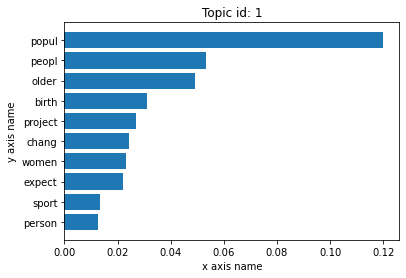


Topic id:  2
('product', 0.06328389)
('price', 0.031337626)
('million', 0.027639283)
('quarter', 0.015288828)
('agricultur', 0.014839729)
('industri', 0.01414814)
('produc', 0.013793156)
('crisi', 0.013542772)
('develop', 0.011397199)
('declin', 0.011237359)


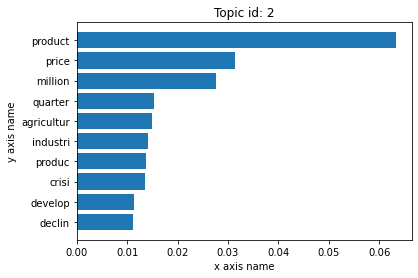


Topic id:  3
('energi', 0.09843536)
('consumpt', 0.057481315)
('product', 0.057006303)
('electr', 0.033913475)
('emiss', 0.033301983)
('renew', 0.01670016)
('gross', 0.016428646)
('final', 0.015622027)
('primari', 0.014941688)
('environment', 0.014081053)


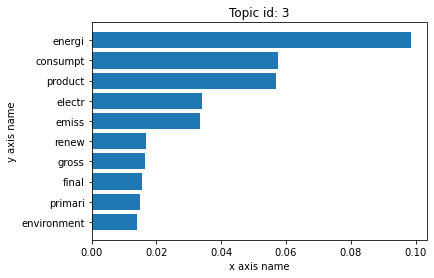


Topic id:  4
('billion', 0.10869561)
('export', 0.10508282)
('trade', 0.094464764)
('china', 0.026533486)
('partner', 0.025713332)
('million', 0.02380786)
('product', 0.022335319)
('manufactur', 0.021680895)
('world', 0.019824764)
('extra', 0.017699137)


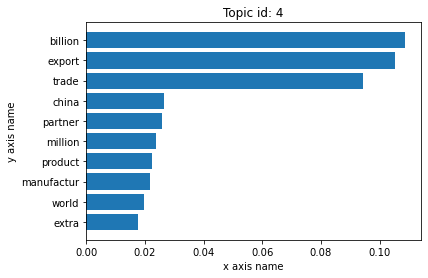


Topic id:  5
('household', 0.07934886)
('cultur', 0.06139802)
('internet', 0.059391033)
('adult', 0.03159627)
('onlin', 0.018811353)
('point', 0.017496325)
('servic', 0.017185723)
('comput', 0.016955024)
('proport', 0.01633198)
('access', 0.015294363)


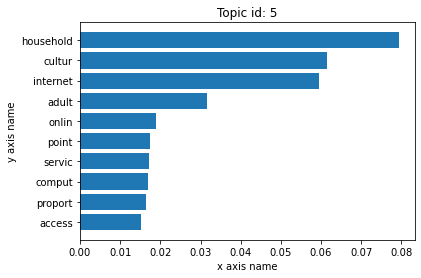


Topic id:  6
('region', 0.14750375)
('sector', 0.035061363)
('economi', 0.024352927)
('employ', 0.022837462)
('person', 0.022644738)
('financi', 0.020130897)
('emploi', 0.018332047)
('activ', 0.018127277)
('capit', 0.017824108)
('labour', 0.017045908)


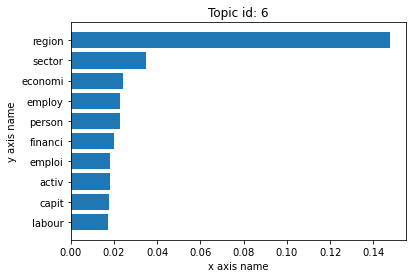


Topic id:  7
('person', 0.06212635)
('group', 0.034454107)
('emploi', 0.03192197)
('health', 0.027776793)
('children', 0.023897119)
('women', 0.020339003)
('peopl', 0.016517973)
('unmet', 0.012261887)
('limit', 0.011623737)
('reason', 0.011372666)


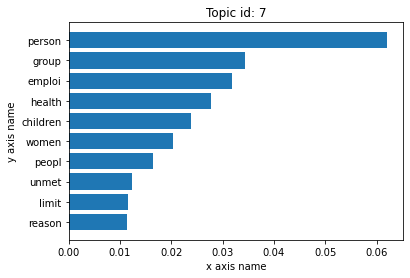


Topic id:  8
('activ', 0.10193726)
('accid', 0.05790873)
('servic', 0.04594818)
('fatal', 0.037995163)
('sector', 0.01791504)
('emploi', 0.01686255)
('person', 0.015685331)
('construct', 0.014892828)
('inform', 0.01467567)
('manufactur', 0.014367642)


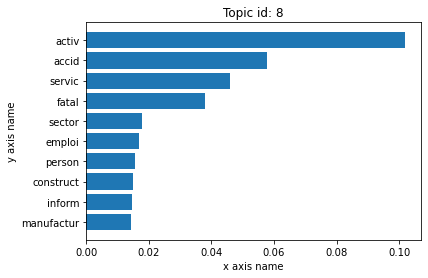


Topic id:  9
('peopl', 0.07714528)
('activ', 0.054337814)
('popul', 0.04687358)
('particip', 0.04657721)
('adult', 0.04423926)
('famili', 0.027598012)
('least', 0.025051277)
('incom', 0.017810546)
('women', 0.016879423)
('formal', 0.016766688)


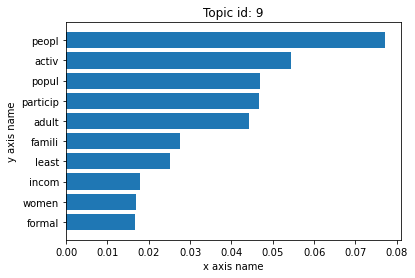


Topic id:  10
('citizen', 0.09851242)
('foreign', 0.05815489)
('resid', 0.038828705)
('nation', 0.027711393)
('permit', 0.024276583)
('first', 0.024226302)
('citizenship', 0.024143104)
('applic', 0.019651024)
('languag', 0.016409328)
('reliabl', 0.012184849)


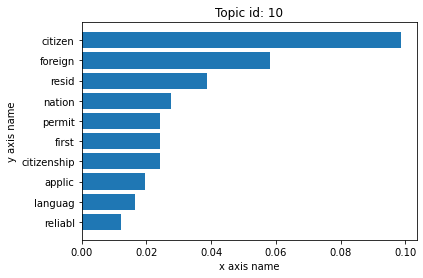


Topic id:  11
('servic', 0.10991903)
('tourist', 0.037516456)
('night', 0.036777157)
('tourism', 0.03675474)
('spent', 0.036351573)
('accommod', 0.032496896)
('resid', 0.030615142)
('travel', 0.01794718)
('domest', 0.014994917)
('million', 0.014592156)


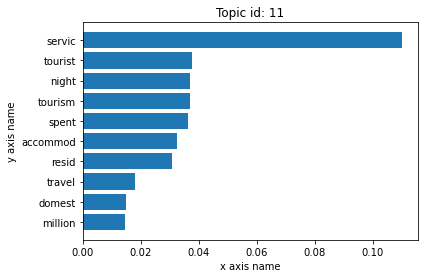


Topic id:  12
('tertiari', 0.050157882)
('student', 0.03960116)
('secondari', 0.039298218)
('graduat', 0.034160394)
('pupil', 0.0168122)
('studi', 0.016301828)
('abroad', 0.01598793)
('recent', 0.015829947)
('proport', 0.015713323)
('attain', 0.015412555)


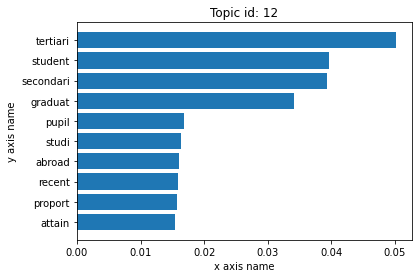


Topic id:  13
('expenditur', 0.07048681)
('benefit', 0.03284315)
('govern', 0.030722959)
('financi', 0.027757363)
('social', 0.024657333)
('ratio', 0.019841298)
('incom', 0.015687248)
('gross', 0.014270107)
('asset', 0.014182936)
('revenu', 0.012985299)


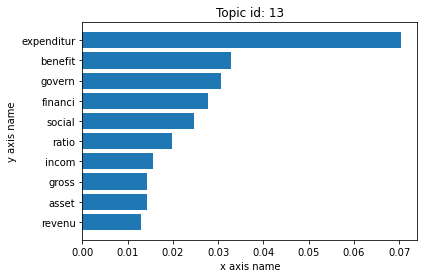


Topic id:  14
('water', 0.0155347055)
('european', 0.015062109)
('develop', 0.013354959)
('target', 0.012563807)
('measur', 0.011442561)
('sustain', 0.010474404)
('progress', 0.010291988)
('toward', 0.009352174)
('environment', 0.008976368)
('trend', 0.008853229)


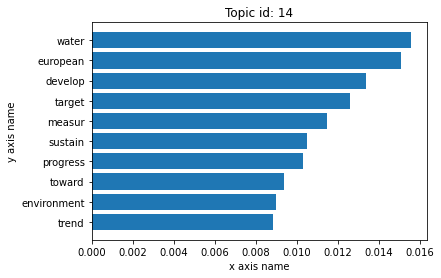


Topic id:  15
('enterpris', 0.078327276)
('economi', 0.0206551)
('pension', 0.014472414)
('turnov', 0.0128967585)
('invest', 0.012643897)
('intern', 0.012378148)
('econom', 0.01189193)
('ukrain', 0.01157848)
('belaru', 0.010589339)
('financi', 0.010566308)


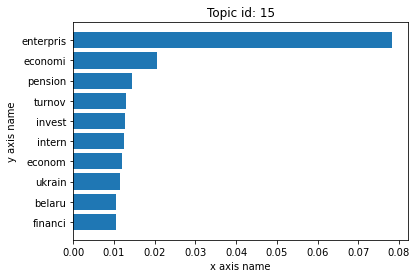


Topic id:  16
('unemploy', 0.06953573)
('candid', 0.054883495)
('potenti', 0.028984487)
('turkei', 0.027757302)
('outsid', 0.02540272)
('labour', 0.025132159)
('serbia', 0.020990707)
('south', 0.020116316)
('macedonia', 0.018882459)
('north', 0.018614074)


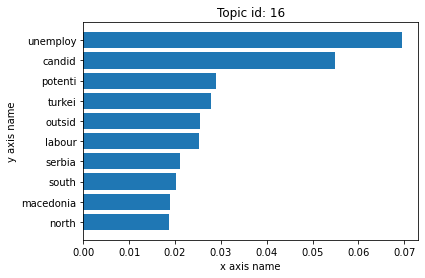


Topic id:  17
('death', 0.06334814)
('inhabit', 0.050538324)
('immigr', 0.04218874)
('cancer', 0.025374781)
('diseas', 0.024253273)
('nativ', 0.022466743)
('origin', 0.019272799)
('women', 0.01890955)
('second', 0.018328192)
('patient', 0.01770085)


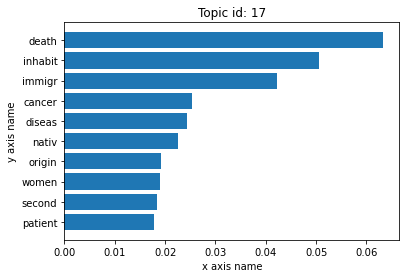


Topic id:  18
('transport', 0.111576386)
('passeng', 0.041463867)
('freight', 0.02827678)
('million', 0.02167414)
('regist', 0.018444825)
('perform', 0.017887432)
('kilometr', 0.017839896)
('vehicl', 0.014957526)
('quarter', 0.013910949)
('intern', 0.013702696)


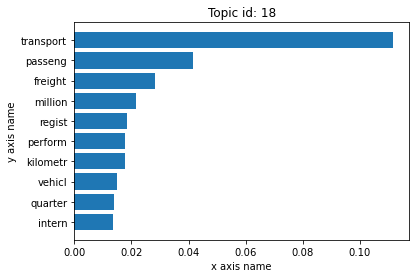


Topic id:  19
('incom', 0.059053198)
('household', 0.049192283)
('poverti', 0.044515315)
('peopl', 0.040413465)
('social', 0.028069565)
('popul', 0.027536705)
('point', 0.023585496)
('children', 0.022314927)
('exclus', 0.015606834)
('depriv', 0.012120484)


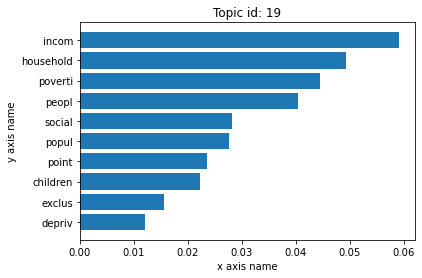


Topic id:  20
('employ', 0.09037193)
('young', 0.08530594)
('peopl', 0.051906627)
('women', 0.038365778)
('point', 0.029195422)
('labour', 0.026885198)
('quarter', 0.026284676)
('emploi', 0.02584849)
('employe', 0.022703765)
('gender', 0.021219553)


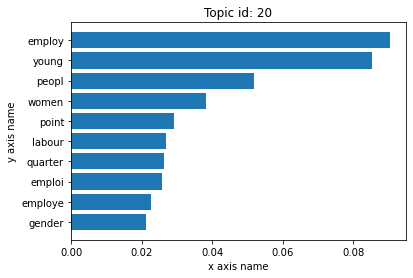

In [17]:

   
for topic_id in range(num_topics):
    print('\nTopic id: ',topic_id+1 )
    top_words = [(a,b) for (a,b) in sorted(lda_model.show_topic(topic_id,topn=10),key=lambda x: x[1], reverse=True)]
    for t in range(len(top_words)):
        print(top_words[t])
    y_axis = [t[0] for t in top_words]
    x_axis = [t[1] for t in top_words] 
    
    plt.barh(y_axis,x_axis)
    plt.gca().invert_yaxis()
    plt.title('title name')
    plt.ylabel('y axis name')
    plt.xlabel('x axis name')
    plt.title('Topic id: '+str(topic_id+1))
    plt.show()        




We end-up with the following interpretations of the 20 topics. Together with the topic names, we also give the coherence scores by topic. We can see that topic 14 "Water resouces and sustainable development" has the highest coherence (0.71) while topic 17 "Health in the migrant population" has the lowest (0.30).   


Topic  1. Coherence: 0.398878  Population projections.  
Topic  2. Coherence: 0.495567  Products and prices.  
Topic  3. Coherence: 0.693183  Energy production, consumption and the environment.  
Topic  4. Coherence: 0.700233  EU exports to the world.  
Topic  5. Coherence: 0.487620  Internet in households.  
Topic  6. Coherence: 0.511891  Regions and economic sectors.  
Topic  7. Coherence: 0.401009  Employment and health.  
Topic  8. Coherence: 0.623845  Accidents at work.  
Topic  9. Coherence: 0.550019  Participation in activities.  
Topic 10. Coherence: 0.497090  Citizenship.  
Topic 11. Coherence: 0.669195  Tourist spending and nights stay.  
Topic 12. Coherence: 0.569557  Education.  
Topic 13. Coherence: 0.598295  Social expenditure and social benefits.  
Topic 14. Coherence: 0.730548  Water resouces and sustainable development.  
Topic 15. Coherence: 0.376975  Enterprises and investments.  
Topic 16. Coherence: 0.483232  Unemployment in candidate countries.  
Topic 17. Coheren

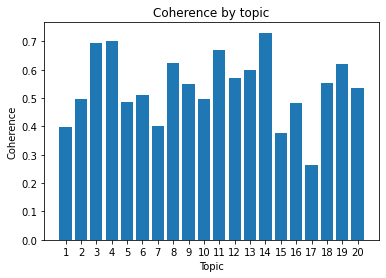

In [18]:
topic_names = [
'Population projections',    
'Products and prices',    
'Energy production, consumption and the environment',   
'EU exports to the world',
'Internet in households',
'Regions and economic sectors',
'Employment and health',
'Accidents at work',
'Participation in activities',
'Citizenship',
'Tourist spending and nights stay',
'Education',
'Social expenditure and social benefits',   
'Water resouces and sustainable development',    
'Enterprises and investments',
'Unemployment in candidate countries',    
'Health in the migrant population',
'Transport freights and passengers',
'Households incomes and poverty',
'Employment in the young population']    

coh_topics = coherence_model_lda.get_coherence_per_topic(segmented_topics=None,with_std=False, with_support=False)

for (i,tn) in enumerate(topic_names):
    print('Topic {0:2d}. Coherence: {1:6f}  {2:s}.  '.format(i+1,coh_topics[i],tn))

fig, ax = plt.subplots()
x=np.arange(num_topics)+1
plt.bar(x=x,height=coh_topics)
plt.xlabel("Topic")
plt.ylabel("Coherence")
plt.title("Coherence by topic")
ax.set_xticks(x)
plt.show()
    

Below we show the dataframe with the most representative document for each topic, completed with the topic intepretations. Many of the 

In [19]:
most_repr_document = sent_topics_sorteddf_mallet
most_repr_document = pd.concat([pd.Series(topic_names,name='Topic interpretation'), most_repr_document],axis=1)
most_repr_document.rename(columns={'Text title':'Most representative article'},inplace=True) 
most_repr_document = most_repr_document[['Topic_Num','Topic interpretation','Topic Keywords','Most representative article','Topic_Perc_Contrib']]
most_repr_document

,Topic_Num,Topic interpretation,Topic Keywords,Most representative article,Topic_Perc_Contrib
0,0,Population projections,"popul, peopl, older, birth, project, chang, wo...",Population projections in the EU,0.9114
1,1,Products and prices,"product, price, million, quarter, agricultur, ...",Farms and farmland in the European Union - sta...,0.9971
2,2,"Energy production, consumption and the environ...","energi, consumpt, product, electr, emiss, rene...",Production of lignite in the EU - statistics,0.9977
3,3,EU exports to the world,"billion, export, trade, china, partner, millio...",Norway-EU - international trade in goods stati...,0.9976
4,4,Internet in households,"household, cultur, internet, adult, onlin, poi...",Digital economy and society statistics - house...,0.8063
5,5,Regions and economic sectors,"region, sector, economi, employ, person, finan...","Water supply, sewerage, waste management and r...",0.9989
6,6,Employment and health,"person, group, emploi, health, children, women...",Main place of work and commuting time - statis...,0.9493
7,7,Accidents at work,"activ, accid, servic, fatal, sector, emploi, p...",Accidents at work - statistics by economic act...,0.9993
8,8,Participation in activities,"peopl, activ, popul, particip, adult, famili, ...",Social participation and integration statistics,0.8624
9,9,Citizenship,"citizen, foreign, resid, nation, permit, first...",Asylum quarterly report,0.9915


### 12. Outputs.
***

A first output in dataframe _topics_terms_df_ is for inspection only: a 20 x 1827 matrix with the distribution of terms per topic. The row sums of this matrix are ones. 

In [20]:

topics_terms_mat = lda_model.get_topics()
print(topics_terms_mat.shape)
topics_terms_df = pd.DataFrame()
for topic_id in range(num_topics):
    topics_terms_df = topics_terms_df.append(pd.Series(topics_terms_mat[topic_id,:].transpose()), ignore_index=True)           
topics_terms_df.rename(columns=id2word, inplace=True)
topics_terms_df.insert(0,'Topic Name',topic_names)
print(topics_terms_df)
topics_terms_df.to_csv('topics_terms_df_SE.write_csv',sep=';')

(20, 1827)
                                           Topic Name     accid    actual  \
0                              Population projections  0.000004  0.000290   
1                                 Products and prices  0.000002  0.002294   
2   Energy production, consumption and the environ...  0.000005  0.000604   
3                             EU exports to the world  0.000003  0.000003   
4                              Internet in households  0.000006  0.000385   
5                        Regions and economic sectors  0.000003  0.000054   
6                               Employment and health  0.000003  0.000003   
7                                   Accidents at work  0.057909  0.000133   
8                         Participation in activities  0.000005  0.000005   
9                                         Citizenship  0.000005  0.000482   
10                   Tourist spending and nights stay  0.000005  0.000005   
11                                          Education  0.000004  

In [21]:
import numpy as np
np.sum(lda_model.get_topics(),axis=1)

array([1.        , 1.0000001 , 0.99999994, 1.0000001 , 0.9999999 ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 0.9999999 , 1.0000001 , 1.        ,
       1.0000001 , 1.0000001 , 0.9999999 , 0.9999999 , 0.99999994],
      dtype=float32)

The next output is for **insertion into the database**. It is the previous matrix in (row,column,value) format, in dataframe _tm_values_, exported to file **_tm_values.csv_** (delimiter=semicolon). All indices are zero-based.

In [22]:
pd.options.display.float_format = '{:.8f}'.format
tm_values = pd.DataFrame(columns=['Topic id','Term id','Probability'])
count = -1
for i in range(topics_terms_mat.shape[0]):
    for j in range(topics_terms_mat.shape[1]):
        count += 1
        tm_values.loc[count,'Topic id']=i
        tm_values.loc[count,'Term id']=j
        tm_values.loc[count,'Probability']=topics_terms_mat[i,j]

print(tm_values)
#pd.options.display.float_format = None
tm_values.to_csv('tm_values_SE.csv',sep=';',index=False)

      Topic id Term id Probability
0            0       0  0.00000379
1            0       1  0.00029020
2            0       2  0.00154713
3            0       3  0.00000379
4            0       4  0.00097013
...        ...     ...         ...
36535       19    1822  0.00000325
36536       19    1823  0.00000325
36537       19    1824  0.00000325
36538       19    1825  0.00000325
36539       19    1826  0.00000325

[36540 rows x 3 columns]


Dataframe _tm_topics_, exported into file **_tm_topics.csv_** (delimiter=semicolon) links the _tm_values_ with the topics information, with the zero-based _Topic id_ key. 

In [23]:
tm_topics = sent_topics_sorteddf_mallet.copy()
tm_topics.rename(columns={'Topic_Num':'Topic id'},inplace=True)
tm_topics.drop(columns=['Topic_Perc_Contrib','Text title'],inplace=True)
tm_topics = pd.concat([tm_topics, pd.Series(topic_names)],ignore_index=True,axis=1)
tm_topics.columns = ['Topic id', 'Topic keywords', 'Topic name']
print(tm_topics)
tm_topics.to_csv('tm_topics_SE.csv',sep=';',index=False)

    Topic id                                     Topic keywords  \
0          0  popul, peopl, older, birth, project, chang, wo...   
1          1  product, price, million, quarter, agricultur, ...   
2          2  energi, consumpt, product, electr, emiss, rene...   
3          3  billion, export, trade, china, partner, millio...   
4          4  household, cultur, internet, adult, onlin, poi...   
5          5  region, sector, economi, employ, person, finan...   
6          6  person, group, emploi, health, children, women...   
7          7  activ, accid, servic, fatal, sector, emploi, p...   
8          8  peopl, activ, popul, particip, adult, famili, ...   
9          9  citizen, foreign, resid, nation, permit, first...   
10        10  servic, tourist, night, tourism, spent, accomm...   
11        11  tertiari, student, secondari, graduat, pupil, ...   
12        12  expenditur, benefit, govern, financi, social, ...   
13        13  water, european, develop, target, measur, sust..

Similarly, dataframe _tm_terms_, exported into file **_tm_terms.csv_** (delimiter=semicolon) which links the _tm_values_ with the terms information, with the zero-based _Term id_ key. 

In [24]:
tm_terms = pd.DataFrame([id2word[t_id] for t_id in id2word],columns=['Term name'])
tm_terms.insert(0,value=range(len(id2word)),column='Term id') 
print(tm_terms)
tm_terms.to_csv('tm_terms_SE.csv',sep=';',index=False)

      Term id   Term name
0           0       accid
1           1      actual
2           2       addit
3           3    advertis
4           4       after
...       ...         ...
1822     1822    occasion
1823     1823      bought
1824     1824       music
1825     1825  darussalam
1826     1826      tablet

[1827 rows x 2 columns]
